In [2]:
import matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import matplotlib.pyplot as plt
from importlib import reload
import functools
import time
%matplotlib inline

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

In [3]:
import landmarks_functions as lf
import utilities as uf

In [176]:
reload(uf)

<module 'utilities' from 'C:\\Users\\g_filo01\\sciebo\\scripts\\Image of the City\\utilities.py'>

# Load the data

In [ ]:
if city_name == 'Boston':
    epsg = 26986
    crs = {'init': 'epsg:26986', 'no_defs': True}
    
    all_buildings = gpd.read_file('C:/Users/g_filo01/sciebo/Scripts/Tools/Outputs/bh_2002_26986.shp').to_crs(epsg=epsg)
    area_to_clip = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/city_center_buffer_100.shp').to_crs(epsg=epsg)
    area_obstructions = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/buffer_4000.shp').to_crs(epsg=epsg)

    buildings, obstructions = lf.select_buildings(all_buildings, area_to_clip, 'ROOF', base = 'GND', 
                                                  area_obstructions = area_obstructions)
    obstructions.to_file(driver='ESRI Shapefile', filename= "Outputs/tmp/"+city_name+"/"+city_name+"_obstructions.shp")
    
elif city_name == 'London':
    epsg = 27700
    crs = {'init': 'epsg:27700', 'no_defs': True}

    all_buildings = gpd.read_file("C:/Users/g_filo01/sciebo/GIS Data/London/Buildings/London_buildings_all.shp")
    area_to_clip = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/Congestion_area_polygon/Polygon.shp')

    buildings, obstructions = lf.select_buildings(all_buildings, area_to_clip, 'max', base = None)
    obstructions.to_file(driver='ESRI Shapefile', filename= "Outputs/tmp/"+city_name+"/"+city_name+"_obstructions.shp")

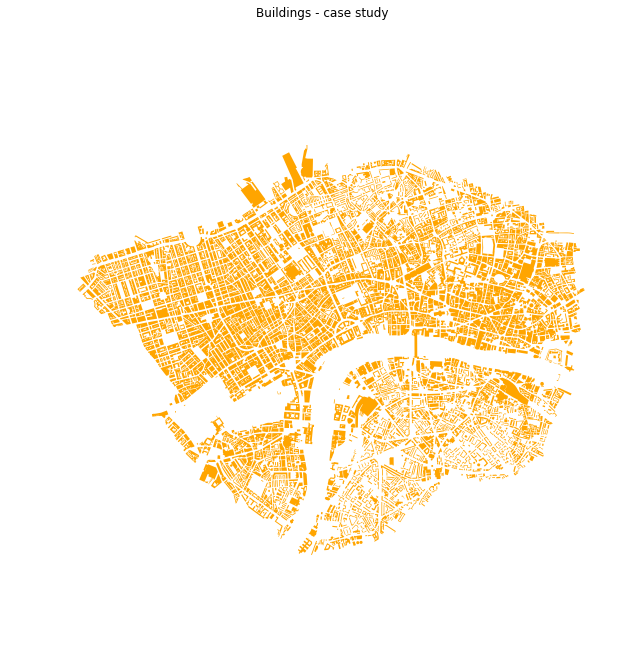

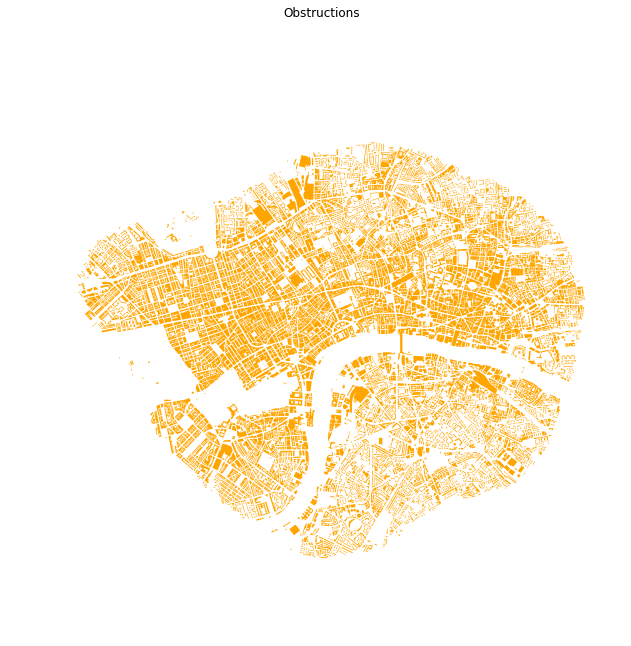

In [177]:
uf.plot_polygons(buildings, title = 'Buildings - case study', black_back = False)
uf.plot_polygons(obstructions, title = 'Obstructions', black_back = False)

In [ ]:
# to simplify 
# when a building is divided in several polygons import in QGIS --> dissolve, single to multipart, join attributes by location
# buildings.to_file(driver='ESRI Shapefile',filename="Outputs/tmp/building_to_dissolve.shp")
# load shapefile again
# buildings = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/bh_26986_simplified.shp').to_crs(epsg=26986)

## 1 - Structural component

In [40]:
%%time

streets = gpd.read_file("Outputs/"+city_name+"/"+city_name+"_paths.shp")
buildings = lf.structural_properties(buildings, obstructions, streets)

Wall time: 1min 11s


In [23]:
%%time
buildings, vis = lf.advance_visibility_buildings(buildings, obstructions)

progress: 99 %Wall time: 2h 52s


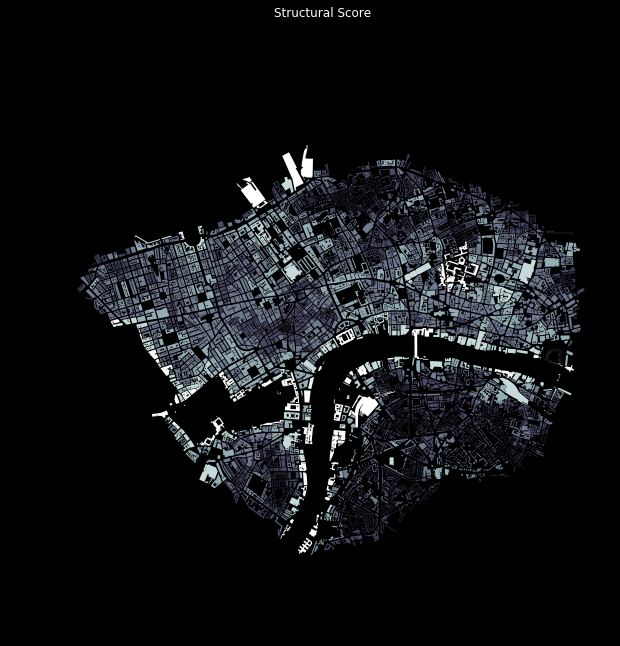

In [188]:
uf.plot_polygons(buildings, column = 'sScore', title = 'Structural Score', 
                scheme = 'fisher_jenks', cmap = 'bone', black_back = True, legend = False)

## 2 - Visual component

In [46]:
buildings.to_file(driver='ESRI Shapefile',filename = "Outputs/tmp/"+city_name+"/"+city_name+"_buildings_sight.shp")

In [138]:
sight_lines = gpd.read_file("Outputs/"+city_name+"/"+city_name+"_sightlines.shp")
sight_lines.head()

,Shape_Leng,Visible,buildingID,nodeID,geometry
0,989.365,1,27131,10,LINESTRING (528249.0162000023 182138.709600003...
1,938.480,1,27131,10,LINESTRING (528249.0162000023 182138.709600003...
2,935.026,1,27131,10,LINESTRING (528249.0162000023 182138.709600003...
3,950.623,1,27131,10,LINESTRING (528249.0162000023 182138.709600003...
4,980.518,1,27131,10,LINESTRING (528249.0162000023 182138.709600003...


In [144]:
buildings = lf.visibility(buildings, sight_lines)

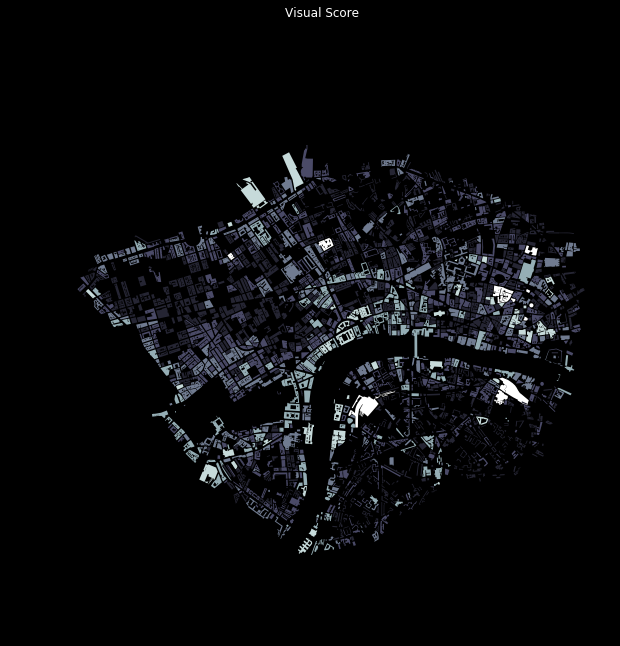

In [186]:
uf.plot_polygons(buildings, column = 'vScore',  title = 'Visual Score',
                scheme = 'fisher_jenks', cmap = 'bone', black_back = True, legend = False)

## 3 - Cultural component

In [41]:
%%time
#load historical polygons

if city_name == 'Boston':
    directoryBoston = "C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/historic_landmarks.shp"
    cultural_elements = (gpd.read_file(directoryBoston)).to_crs(epsg=epsg)
    buildings = ic.cultural_meaning(buildings, cultural_elements)

if city_name == 'London':
    directoryLondon = "C:/Users/g_filo01/sciebo/GIS Data/London/Historic_England/Listed_building_selection.shp"
    cultural_elements = (gpd.read_file(directoryLondon)).to_crs(epsg=epsg)
    cultural_elements['Grade'] = cultural_elements['Grade'].map( lambda x: 3 if x == 'I' else 2 if x == 'II*' else 1 
                                       if x == 'II' else 0)
    buildings = lf.cultural_meaning(buildings, cultural_elements, score = 'Grade')

Wall time: 5.86 s


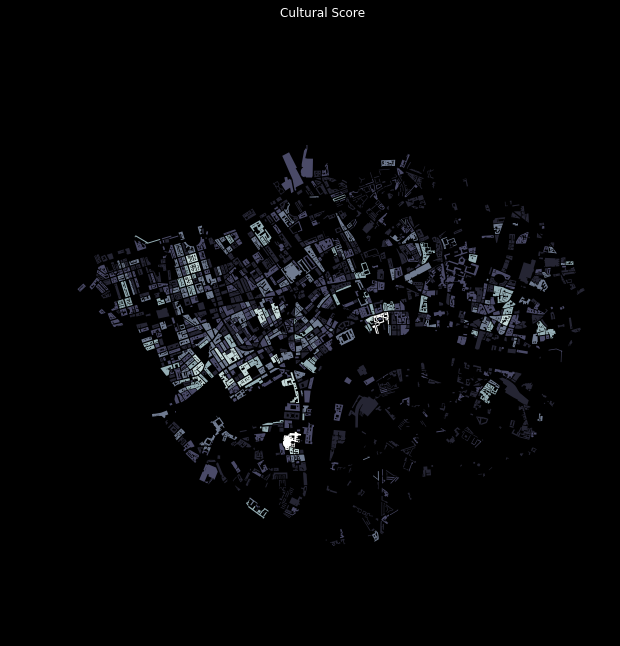

In [184]:
uf.plot_polygons(buildings, column = 'cult_sc', title = 'Cultural Score', 
                scheme = 'fisher_jenks', cmap = 'bone', black_back = True, legend = False)

## 4 - Pragmatic component

In [58]:
university = ['university', 'college', 'research']
commercial = ['bank', 'service',  'commercial',  'retail', 'Retail',  'pharmacy', 'commercial;educa', 'shop', 'Commercial',
                       'supermarket', 'offices', 'foundation', 'office', 'books', 'Commercial services']
residential = [ 'apartments', None, 'NaN', 'residential','flats', 'no', 'houses', 'garage', 'garages']
attractions = ['Attractions', 'museum',  'castle', 'cathedral', 'attraction','aquarium', 'monument',  'gatehouse',
               'terrace', 'tower', 'Attraction And Leisure']
hospitality = [ 'hotel',  'hostel', 'guest_house']
eating_drinking = [ 'restaurant', 'fast_food', 'cafe', 'bar',  'pub', 'Accommodation, eating and drinking',]
public = ['post_office', 'townhall', 'public_building',  'library','civic', 'courthouse', 'public', 'embassy',
          'Public infrastructure', 'community_centre', 'parking', 'dormitory']
library = ['library']
sport = ['stadium', 'Sport and entertainment', 'Sports Or Exercise Facility']
entertainment = [ 'exhibition_centr','theatre', 'cinema']
education = ['school', 'kindergarten', 'Education', 'Education and health']
religious = ['church', 'place_of_worship','convent', 'rectory', 'Religious Buildings']
emergency_service = [ 'fire_station','police', 'Emergency Service']
transport = [ 'station', 'train_station']
medical_care = ['hospital', 'doctors', 'dentist','clinic','veterinary', 'Medical Care']
industrial = [ 'industrial', 'factory', 'construction', 'Manufacturing and production',  'gasometer', 'data_center']
cultural = ['club_house','gallery', 'arts_centre','Cultural Facility']
military = ['general aviation', 'Barracks']
transport =['Transport', 'Road Transport', 'station', 'subway_entrance', 'bus_station']


drop = ['roof', 'garage', 'storage_tank', 'shed', 'silo',  'parking',  'toilets',
  'picnic_site','hut', 'information',  'viewpoint', 'atm', 'building',  'tower',  'terrace',  'canopy', 'smokestack',  
 'greenhouse', 'fuel']

### London

In [50]:
# polygons
imp = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/TQ_ImportantBuilding2.shp').to_crs(epsg = epsg)
fs = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/TQ_FunctionalSite.shp').to_crs(epsg = epsg)
stations = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/TQ_RailwayStation.shp').to_crs(epsg = epsg)
osm_buildings = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OSM/buildings.shp').to_crs(epsg = epsg)
osm_buildings = osm_buildings[osm_buildings['type'] != None]

# points # from Ordnance Survey
POI = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/London_POI.shp').to_crs(epsg = epsg)

In [61]:
%%time
gdf = [imp, fs, stations, osm_buildings]
columns_lu = ['BUILDGTHEM', 'SITETHEME', 'CLASSIFICA', 'type']
new_columns = ['land_use_1', 'land_use_2', 'land_use_3', 'land_use_4']

for i, p in enumerate(gdf):
    obstructions = lf.land_use_from_polygons(obstructions, p, new_columns[i], columns_lu[i])

TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533793.26810412214 179574.13192187241 at 533793.26810412214 179574.13192187241
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533793.26810412214 179574.13192187241 at 533793.26810412214 179574.13192187241
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533793.26810412214 179574.13192187241 at 533793.26810412214 179574.13192187241
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533793.26810412214 179574.13192187241 at 533793.26810412214 179574.13192187241
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533793.26810412214 179574.13192187241 at 533793.26810412214 179574.13192187241
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533793.26810412214 179574.13192187241 at 533793.26810412214 179574.13192187241
TopologyException: Input geom 0 is invalid: Self-int

TopologyException: Input geom 0 is invalid: Self-intersection at or near point 537663.65725940093 183363.98925880864 at 537663.65725940093 183363.98925880864
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 537663.65725940093 183363.98925880864 at 537663.65725940093 183363.98925880864
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 537663.65725940093 183363.98925880864 at 537663.65725940093 183363.98925880864
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 537663.65725940093 183363.98925880864 at 537663.65725940093 183363.98925880864
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 537663.65725940093 183363.98925880864 at 537663.65725940093 183363.98925880864
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-inter

TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-intersection at

Wall time: 1min 8s


In [62]:
%%time
gdf = [POI]
columns_lu = ['main']
new_columns = ['land_use_5']

for i, p in enumerate(gdf):
    obstructions = lf.land_use_from_points(obstructions, p, new_columns[i], columns_lu[i])

Wall time: 14.3 s


In [63]:
obstructions['land_use_1'][obstructions['land_use_1'] == 'NaN'] = obstructions['land_use_2']
obstructions['land_use_1'][obstructions['land_use_1'] == 'NaN'] = obstructions['land_use_3']
obstructions['land_use_1'][obstructions['land_use_1'] == 'NaN'] = obstructions['land_use_5']
obstructions['land_use_1'][obstructions['land_use_1'] == 'NaN'] = obstructions['land_use_4']
obstructions.head()

,height,base,area,buildingID,geometry,land_use_1,land_use_2,land_use_3,land_use_4,land_use_5
0,3.180,0,208.221,0,"POLYGON ((529891.7900001183 183628.2199995402,...",Transport,NaN,NaN,NaN,Transport
1,12.210,0,942.013,0,"POLYGON ((529908.4400001189 183173.1599995393,...",None,NaN,NaN,None,NaN
2,12.270,0,331.740,0,"POLYGON ((529866.5000001183 183238.34999954, 5...",Commercial services,NaN,NaN,None,Commercial services
3,27.820,0,1637.525,0,"POLYGON ((527543.2900001081 182478.7399995871,...",Attractions,NaN,NaN,NaN,Attractions
4,11.590,0,1441.718,0,"POLYGON ((527005.8700001058 182333.7399995989,...",Education,Education,NaN,NaN,Education and health


In [64]:
obstructions['land_use_1'] = obstructions['land_use_1'].map( lambda x: 'university' if x in university
                                                          else 'commercial' if x in commercial
                                                          else 'residential' if x in residential
                                                          else 'attractions' if x in attractions
                                                          else 'library' if x in library
                                                          else 'hospitality' if x in hospitality
                                                          else 'eating_drinking' if x in eating_drinking
                                                          else 'public' if x in public
                                                          else 'sport' if x in sport
                                                          else 'entertainment' if x in entertainment
                                                          else 'education' if x in education
                                                          else 'religious' if x in religious
                                                          else 'emergency_service' if x in emergency_service
                                                          else 'industrial' if x in industrial
                                                          else 'cultural' if x in cultural
                                                          else 'transport' if x in transport
                                                          else 'medical_care' if x in medical_care
                                                          else 'military' if x in military
                                                          else x)

obstructions.land_use_1.unique()

array(['transport', 'residential', 'commercial', 'attractions',
       'education', 'public', 'religious', 'eating_drinking', 'industrial',
       'sport', 'emergency_service', 'cultural', 'medical_care',
       'hospitality', 'military'], dtype=object)

In [65]:
obstructions['land_use'] = obstructions['land_use_1']
obstructions.drop(['land_use_1', 'land_use_2', 'land_use_3', 'land_use_4', 'land_use_5'], axis = 1, inplace = True)

### Boston

In [ ]:
# loading polygons data

parcels = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/Parcels_2016/parcels.shp').to_crs(epsg = epsg)
osm_buildings = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/OSM/buildings.shp').to_crs(epsg = epsg)
osm_buildings = osm_buildings[osm_buildings['type'] != None]

In [ ]:
%%time
gdf = [parcels, osm_buildings]
columns_lu = ['LU', 'type']
new_columns = ['land_use_1', 'land_use_2']
for i, p in enumerate(gdf):
    obstructions = lf.land_use_from_polygons(obstructions, p, new_columns[i], columns_lu[i])

In [ ]:
residential_b = ['Residential Condo Unit', 'Apartments 4-6 Units', 'Residential Two Family', 
               'Apartments 7 Units above', 'Residential Single Family', 'Condominium Parking', 'Residential Three Family',
               'Condominium Master', 'Residential Land']
commercial_b = ['Commercial', 'Commercial Land', 'Mixed Use Res/Comm',  'Commercial Condo Unit']
public_b = ['Exempt', 'Exempt 121A']

obstructions['land_use_1'] = obstructions['land_use_1'].map( lambda x: 'residential' if x in residential_b
                                                          else 'commercial' if x in commercial_b
                                                          else 'public' if x in public_b
                                                          else 'industrial' if x == 'Industrial'
                                                          else x)

In [ ]:
obstructions['land_use_1'] = obstructions['land_use_1'].map( lambda x: 'university' if x in university
                                                          else 'commercial' if x in commercial
                                                          else 'residential' if x in residential
                                                          else 'attractions' if x in attractions
                                                          else 'library' if x in library
                                                          else 'hospitality' if x in hospitality
                                                          else 'eating_drinking' if x in eating_drinking
                                                          else 'public' if x in public
                                                          else 'sport' if x in sport
                                                          else 'entertainment' if x in entertainment
                                                          else 'education' if x in education
                                                          else 'religious' if x in religious
                                                          else 'emergency_service' if x in emergency_service
                                                          else 'industrial' if x in industrial
                                                          else 'cultural' if x in cultural
                                                          else 'transport' if x in transport
                                                          else 'medical_care' if x in medical_care
                                                          else 'military' if x in military
                                                          else x)

obstructions.land_use_1.unique()

#### Other data from Boston

In [ ]:
# libraries and schools

schools = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/schools.shp'
                        ).to_crs(epsg=26986))

universities = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/universities.shp'
                        ).to_crs(epsg=26986))

p_schools = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/private_schools.shp'
                        ).to_crs(epsg=26986))

libraries = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/libraries.shp'
                        ).to_crs(epsg=26986))

pools = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/pools.shp'
                        ).to_crs(epsg=26986))

police = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/police_stations.shp'
                        ).to_crs(epsg=26986))

In [ ]:
%%time

df_list = [schools, p_schools, libraries, universities, pools, police]
classification = ['education', 'education', 'library', 'university', 'sport', 'emergency_service']

index_geometry = obstructions.columns.get_loc("geometry")+1 
index_land_use = obstructions.columns.get_loc("land_use_1")+1
list_lu = ['residential', 'commercial', 'NaN']

for i, t in enumerate(df_list):
    sindex = t.sindex

    for row in obstructions.itertuples():
        g = row[index_geometry] #geometry
    
        possible_matches_index = list(sindex.intersection(g.bounds))
        possible_matches = t.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches.intersects(g)]
                
        if (len(precise_matches)==0): continue
        if (row[index_land_use] not in list_lu): continue
        else: obstructions.set_value(row[0], 'land_use_1', classification[i])

In [ ]:
obstructions['land_use_1'][obstructions['land_use_1'] == 'NaN'] = obstructions['land_use_2']
obstructions['land_use'] = obstructions['land_use_1']
obstructions.drop(['land_use_1', 'land_use_2', 'land_use_3', 'land_use_4', 'land_use_5'], axis = 1, inplace = True)
obstrucions.head()

### Pragmatic meaning computation

In [66]:
%%time
obstructions = lf.pragmatic_meaning(obstructions)
buildings = pd.merge(buildings, obstructions[['prag', 'land_use', 'buildingID']], how = 'left', 
                     left_on = "buildingID", right_on = "buildingID")

Wall time: 32.8 s


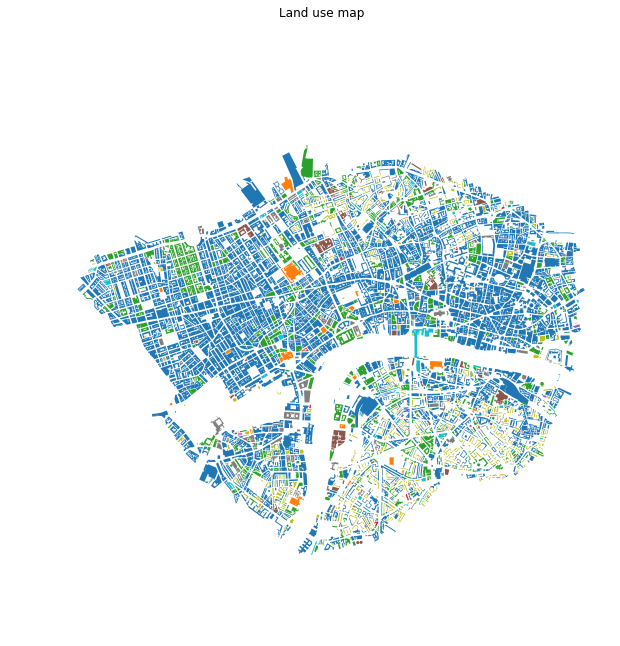

In [182]:
uf.plot_polygons(buildings, column = 'land_use', title = 'Land use map', black_back = False)

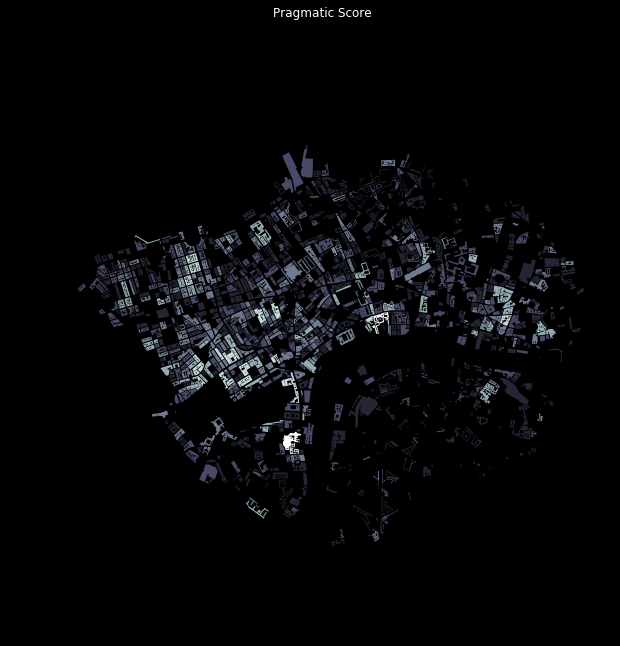

In [189]:
uf.plot_polygons(buildings, column = 'cult_sc', title = 'Pragmatic Score', 
                scheme = 'fisher_jenks', cmap = 'bone', black_back = True, legend = False)

# 5 - Final scores

In [147]:
buildings = lf.compute_scores(buildings)
buildings.crs = crs

In [151]:
buildings.head()

,a_vis,area,base,buildingID,ext,fac,height,neigh,r_height,road,...,cult_sc,vis_sc,neigh_sc,road_sc,vScore,sScore,vScore_sc,sScore_sc,gScore,gScore_sc
0,406289.254,568.261,0,13472,568.261,1640.797,100.910,4.000,100.910,5.253,...,0.000,0.529,1.000,0.942,0.351,0.633,0.355,0.868,0.523,0.752
1,25874.887,244.921,0,14303,244.921,374.247,16.805,19.000,16.805,0.925,...,0.000,0.124,0.858,0.990,0.077,0.385,0.078,0.428,0.259,0.319
2,165133.567,456.620,0,14313,456.620,169.216,12.800,12.000,12.800,16.517,...,0.000,0.301,0.925,0.817,0.161,0.448,0.163,0.540,0.338,0.448
3,33416.213,385.922,0,14314,385.921,293.025,18.257,12.000,18.257,73.487,...,0.000,0.078,0.925,0.187,0.055,0.243,0.055,0.175,0.148,0.135
4,267367.536,315.001,0,14315,315.001,85.235,5.172,11.000,5.172,5.292,...,0.000,0.257,0.934,0.941,0.133,0.535,0.134,0.695,0.358,0.481


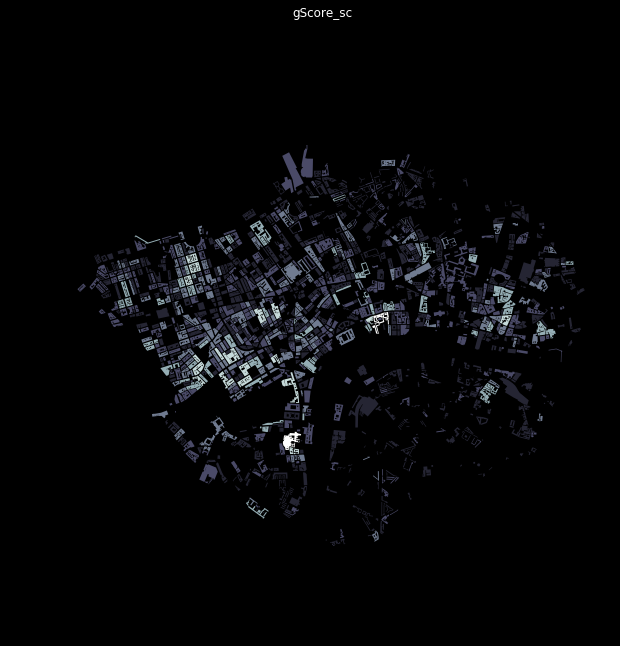

In [190]:
uf.plot_polygons(buildings, column = 'gScore_sc', title = 'Global Score', 
                scheme = 'fisher_jenks', cmap = 'bone', black_back = True, legend = False)

In [192]:
%%time
buildings = lf.local_scores(buildings, 800)

Wall time: 3min 49s


In [152]:
buildings.to_file(driver='ESRI Shapefile',filename="Outputs/"+city_name+"/"+city_name+"_landmarks.shp")